In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
source_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'

In [3]:
genome = 'Pst_104E_v12_p_ctg'

In [4]:
out_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis'

In [5]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [6]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.REPET.gff > {out_dir}/{genome}.REPET.gff

In [146]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

In [8]:
TE_post_analysis_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/REPET/Pst79_p/Pst79_p_full_annotate/postanalysis'

In [9]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [10]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [11]:
#this needs to be fixed up to pick the proper summary table
p_repet_summary_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#check if I can filter the tab files for removing all TEs that are on the 2000 plus contigs
#remove tRNAs TEs with infernal

p_repet_summary_df['Code'] = p_repet_summary_df['TE'].apply(lambda x: x.split('_')[0])

code_keys = p_repet_summary_df['Code'].unique()

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon noCat', 'Retrotransposon LARD',\
             'Retrotransposon LARD', 'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon noCat',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']

code_dict = dict(zip(code_keys, code_long))

In [12]:
p_repet_summary_df['Code long'] = p_repet_summary_df['Code'].apply(lambda x: code_dict[x])

p_repet_summary_sum_df = pd.pivot_table(p_repet_summary_df, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)

p_repet_summary_mean_df = pd.pivot_table(p_repet_summary_df, values='length', index='Code long', aggfunc=np.mean)

pd.concat([p_repet_summary_sum_df,p_repet_summary_mean_df], axis=1 )

copies      covg       length
Code long                                             
DNA_transposon Helitron    1075    817566  2989.764706
DNA_transposon MITE        3789    886304   490.240741
DNA_transposon Maverick     268    345406  8562.666667
DNA_transposon TIR        19166  12711595  4020.474359
DNA_transposon noCat       5286   2376456  3034.734513
Potential Host Gene        1372   1375304  6120.490566
Retrotransposon DIRS       1337   1049299  6874.526316
Retrotransposon LARD      10752   4947564  5407.736111
Retrotransposon LINE        323    237992  4446.625000
Retrotransposon LTR       18893  16276421  6384.627841
Retrotransposon PLE          75     41843  8954.000000
Retrotransposon SINE        163     31138   317.923077
Retrotransposon TRIM        507    238695  1583.434783
Retrotransposon noCat       112    101098  4365.857143
noCat                      1218    850828  1679.829268

In [13]:
#pull out the top 20 TEs based on coverage in the coverage dataframe
p_repet_top_20 = p_repet_summary_df[~(p_repet_summary_df['Code']=='PotentialHostGene')].sort_values(by='covg', ascending=False).reset_index(drop=True).iloc[0:20,:]

In [14]:
p_repet_top_20.head()

TE  length    covg  frags  \
0                  DXX_MCL2_Pst79_REPET-B-G1715-Map3   18812  335432    225   
1  DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4_reversed   13182  333753    419   
2               DXX_MCL287_Pst79_REPET-B-R3576-Map14   28094  175364    147   
3              noCat_MCL102_Pst79_REPET-B-R139-Map11   12696  171929     77   
4           RLX-comp_MCL8_Pst79_REPET-B-P528.25-Map3    9453  152539     56   

   fullLgthFrags  copies  fullLgthCopies  meanId   sdId  minId  \
0              3     187               3   87.87  10.61  59.80   
1              7     356               8   80.27   9.44  59.00   
2              1     125               1   79.67   9.67  55.40   
3              5      63               5   75.30  16.61  55.30   
4              9      41              10   91.29   9.88  67.35   

           ...           maxLgth  meanLgthPerc  sdLgthPerc  minLgthPerc  \
0          ...           18818.0          9.54       20.96         0.11   
1          ...           13264.0          7.12       18.65         0.16   
2          ...           28085.0          5.04       13.43         0.07   
3          ...           12857.0         21.50       28.14         0.17   
4          ...            9901.0         39.37       41.85         0.39   

   q25LgthPerc  medLgthPerc  q75LgthPerc  maxLgthPerc        Code  \
0         0.48         1.66         6.02       100.03         DXX   
1         0.59         1.43         5.48       100.62  DTX-incomp   
2         0.24         0.59         1.61        99.97         DXX   
3         1.24        12.53        28.64       101.27       noCat   
4         2.36        14.18        92.03       104.74    RLX-comp   

              Code long  
0  DNA_transposon noCat  
1    DNA_transposon TIR  
2  DNA_transposon noCat  
3                 noCat  
4   Retrotransposon LTR  

[5 rows x 30 columns]

In [15]:
p_repet_top_20_TE = p_repet_top_20['TE']

In [16]:
['_'.join(x.split('_')[:2]) for x in p_repet_top_20_TE]

['DXX_MCL2',
 'DTX-incomp_MCL9',
 'DXX_MCL287',
 'noCat_MCL102',
 'RLX-comp_MCL8',
 'DTX-incomp_MCL78',
 'DTX-incomp_MCL75',
 'RLX-incomp_MCL10',
 'DTX-comp_MCL40',
 'RLX-incomp-chim_MCL20',
 'DTX-incomp_MCL16',
 'RLX-incomp_MCL2',
 'DTX-incomp-chim_MCL2',
 'RXX-LARD-chim_MCL69',
 'RLX-comp_MCL39',
 'RYX-comp-chim_MCL293',
 'RLX-incomp_MCL81',
 'RLX-comp_MCL215',
 'DTX-incomp_MCL38',
 'RLX-incomp_MCL18']

In [17]:
#now filter the gff dataframe to delete all the high coverage contigs
#This might would have to be fixed as well. If we don't delete it as files should be already filtered
contigs_smaller_2000 = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly/pcontig_smaller_2000.txt',\
                                  header=None)[0].tolist()

In [147]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

In [148]:
p_repet_gff_filtered = p_repet_gff[p_repet_gff[0].isin(contigs_smaller_2000)].reset_index(drop=True)

In [155]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':

        TE_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-,_]*_[^;| ]*)_'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        
        SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        #if "#" in _id:
        #     blast_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*[_]?[A-Z,a-z,0-9,-]*[_|#|0-9]+?:[A-Z,a-z,0-9,-,:]*)'
        #else:
        #    blast_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([\w+|:|-]*)'
        blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [ ]:
p_repet_gff_filtered['ID'] = p_repet_gff_filtered.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

ID=ms7308_pcontig_193_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3;Target=DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3 8186 8708;TargetLength=9009;TargetDescription=CI:87 coding:(TE_BLRtx: hAT-1_GM:ClassII:TIR:hAT: 9.26% | hAT-1_PTrit:ClassII:TIR:hAT: 25.90% | hAT-5_PGr:ClassII:TIR:hAT: 5.93% TE_BLRx: ATHAT2p:ClassII:TIR:hAT: 5.18% | TEMPINDAS_1p:ClassII:TIR:hAT: 6.95% | hAT-1_PGr_1p:ClassII:TIR:hAT: 32.62% | hAT-4_PGr_1p:ClassII:TIR:hAT: 45.50% profiles: PF00271.26_Helicase_C_NA_HEL_11.6: 70.51%(70.51%) | PF05699.9_Dimer_Tnp_hAT_NA_Tase_21.4: 100.00%(100.00%)) struct:(TElength: >1000bps ORF: >1000bps) other:(Other_profiles: PF14372.1_DUF4413_NA_OTHER_27.0: 98.02%(98.02%) SSRCoverage:0.15);Identity=80.2
ID=mp7308-1_pcontig_193_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3;Parent=ms7308_pcontig_193_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3;Target=DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3 8186 8708;Identity=80.2
ID=ms7309_pcontig_193_DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4_rev

In [151]:
#filter out potential host genes
p_repet_gff_filtered = p_repet_gff_filtered[~p_repet_gff_filtered[8].str.contains("Potential")]

In [152]:
p_repet_gff_filtered.head()

0                      1           2      3      4    5  6  7  \
0  pcontig_193  Pst79p_anno_REPET_TEs       match  54973  55495  0.0  -  .   
1  pcontig_193  Pst79p_anno_REPET_TEs  match_part  54973  55495  0.0  -  .   
2  pcontig_193  Pst79p_anno_REPET_TEs       match    359   1264  0.0  -  .   
3  pcontig_193  Pst79p_anno_REPET_TEs  match_part    359   1264  0.0  -  .   
4  pcontig_193  Pst79p_anno_REPET_TEs       match   1430   3581  0.0  -  .   

                                                   8  \
0  ID=ms7308_pcontig_193_DTX-incomp-chim_MCL5_Pst...   
1  ID=mp7308-1_pcontig_193_DTX-incomp-chim_MCL5_P...   
2  ID=ms7309_pcontig_193_DTX-incomp_MCL9_Pst79_RE...   
3  ID=mp7309-1_pcontig_193_DTX-incomp_MCL9_Pst79_...   
4  ID=ms7310_pcontig_193_DTX-incomp_MCL9_Pst79_RE...   

                                         ID  
0                DTX-incomp-chim_MCL5_Pst79  
1                DTX-incomp-chim_MCL5_Pst79  
2  DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4  
3  DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4  
4  DTX-incomp_MCL9_Pst79_REPET-B-G1698-Map4

In [23]:
p_repet_gff_2 = p_repet_gff_filtered.loc[:,:]

In [24]:
p_repet_gff_2.drop_duplicates(subset=[3,5,'ID'], inplace=True)

In [25]:
p_repet_gff_2['Length'] = p_repet_gff_2[4] - p_repet_gff_2[3]

In [26]:
p_repet_gff_len = p_repet_gff_2.groupby('ID')['Length'].sum()

In [27]:
p_repet_gff_len.sort_values(ascending=False)[:20]

ID
hAT-5_PSt:ClassII:TIR:hAT             1143889
Academ-1_PGr:ClassII:?:Academ          872967
Gypsy-17_PGr-I_1p:ClassI:LTR:Gypsy     509470
Gypsy-17_PGr-I:ClassI:LTR:Gypsy        467152
hAT-8_PGr:ClassII:TIR:hAT              466774
RLX-incomp_MCL2                        427055
Academ-1_PGr_1p:ClassII:?:Academ       422204
Academ-1_PGr_2p:ClassII:?:Academ       420384
LTR-3_PSt-LTR:ClassI:LTR:?             419063
RLX-incomp_MCL10                       413336
Gypsy-19_PGr-I:ClassI:LTR:Gypsy        410923
DTX-incomp_MCL9                        406598
DXX_MCL2                               368749
Gypsy-19_PGr-I_2p:ClassI:LTR:Gypsy     365840
Gypsy-12_PGr-I:ClassI:LTR:Gypsy        361278
DNA-9_PSt:ClassII:?:?                  351613
Gypsy-3_PSt-I:ClassI:LTR:Gypsy         349446
Gypsy-22_PGr-I_1p:ClassI:LTR:Gypsy     348956
MuDR-3_PGr_1p:ClassII:TIR:MuDR         344261
Gypsy-7_PSt-I:ClassI:LTR:Gypsy         333505
Name: Length, dtype: int64

In [111]:
p_repet_gff_2['Length'].sum()

103820272

In [133]:
TE_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9,-]*_[^;| ]*)_'
TE_prog = re.compile(TE_pattern)
#TE_match = TE_prog.search(_id)


In [153]:
test_list = [x.split(';')[0] for x in p_repet_gff[p_repet_gff[8].str.contains('DTX-incomp-chim_MCL5_Pst79')][8]]

In [154]:
test_list

['ID=ms7308_pcontig_193_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp7308-1_pcontig_193_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms1463_pcontig_184_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp1463-1_pcontig_184_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms63220_pcontig_095_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp63220-1_pcontig_095_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms67727_pcontig_073_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp67727-1_pcontig_073_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms49983_pcontig_078_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp49983-1_pcontig_078_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms66254_pcontig_080_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp66254-1_pcontig_080_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=ms33680_pcontig_081_DTX-incomp-chim_MCL5_Pst79_REPET-B-G1667-Map3',
 'ID=mp33680-1_pcontig_081_DTX-incomp-chim_

In [134]:
for _id in test_list:
    TE_match = TE_prog.search(_id)
    print(TE_match.group(1))

RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_Pst79_REPET-B-G1647-Map4
RLX-incomp_MCL2_

In [125]:
p_repet_gff[(p_repet_gff[8].str.contains('Gypsy-3_PTrit-I_1p:ClassI:LTR:Gypsy') )| (p_repet_gff[8].str.contains('RLX-incomp_MCL2_Pst79_REPET-B-G1647'))]

0                         1           2       3       4  \
302     pcontig_164     Pst79p_anno_REPET_TEs       match   15767   15817   
1934    pcontig_095     Pst79p_anno_REPET_TEs       match  133726  133857   
4890    pcontig_104  Pst79p_anno_REPET_blastx       match   37837   37878   
4891    pcontig_104  Pst79p_anno_REPET_blastx  match_part   37837   37878   
7848    pcontig_073     Pst79p_anno_REPET_TEs       match   28363   46183   
10121   pcontig_074     Pst79p_anno_REPET_TEs       match  341856  342213   
10123   pcontig_074     Pst79p_anno_REPET_TEs       match  342214  342519   
10361   pcontig_074     Pst79p_anno_REPET_TEs       match  187359  187650   
10469   pcontig_074     Pst79p_anno_REPET_TEs       match   25045   26389   
10472   pcontig_074     Pst79p_anno_REPET_TEs       match   26595   27155   
13920   pcontig_075     Pst79p_anno_REPET_TEs       match  273566  275027   
14119   pcontig_075     Pst79p_anno_REPET_TEs       match  131673  131695   
14224   pcontig_075     Pst79p_anno_REPET_TEs       match   76264   76619   
14226   pcontig_075     Pst79p_anno_REPET_TEs       match  105341  106562   
14231   pcontig_075     Pst79p_anno_REPET_TEs       match   24972   28000   
14233   pcontig_075     Pst79p_anno_REPET_TEs       match   33603   47018   
16728   pcontig_077     Pst79p_anno_REPET_TEs       match  203143  203517   
18312   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18314   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18340   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18363   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18364   pcontig_078     Pst79p_anno_REPET_TEs  match_part   98131   98166   
18365   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18367   pcontig_078     Pst79p_anno_REPET_TEs       match   98131   98166   
18595   pcontig_078     Pst79p_anno_REPET_TEs       match  289316  290098   
21607   pcontig_079     Pst79p_anno_REPET_TEs       match   38335   38741   
24586   pcontig_082     Pst79p_anno_REPET_TEs       match  285052  295441   
24587   pcontig_082     Pst79p_anno_REPET_TEs  match_part  285052  295441   
24592   pcontig_082     Pst79p_anno_REPET_TEs       match  247859  249091   
26690   pcontig_083     Pst79p_anno_REPET_TEs       match  224709  225146   
...             ...                       ...         ...     ...     ...   
524708  pcontig_177     Pst79p_anno_REPET_TEs       match   22544   25265   
525088  pcontig_177  Pst79p_anno_REPET_blastx       match    1687    1716   
525089  pcontig_177  Pst79p_anno_REPET_blastx  match_part    1687    1716   
528341  pcontig_139     Pst79p_anno_REPET_TEs       match   11418   11980   
528343  pcontig_139     Pst79p_anno_REPET_TEs       match   12183   13525   
528616  pcontig_140     Pst79p_anno_REPET_TEs       match   25893   27405   
529151  pcontig_150     Pst79p_anno_REPET_TEs       match   32157   33669   
529645  pcontig_152     Pst79p_anno_REPET_TEs       match   27404   28747   
530362  pcontig_154     Pst79p_anno_REPET_TEs       match    6103    7616   
532366  pcontig_112     Pst79p_anno_REPET_TEs       match   91809   93588   
532369  pcontig_112     Pst79p_anno_REPET_TEs       match   98584   99318   
532426  pcontig_112     Pst79p_anno_REPET_TEs       match   31607   33323   
532427  pcontig_112     Pst79p_anno_REPET_TEs  match_part   31607   33323   
532428  pcontig_112     Pst79p_anno_REPET_TEs       match   34230   40085   
532429  pcontig_112     Pst79p_anno_REPET_TEs  match_part   34230   36449   
532430  pcontig_112     Pst79p_anno_REPET_TEs  match_part   37008   40085   
532431  pcontig_112     Pst79p_anno_REPET_TEs       match   40839   41311   
532432  pcontig_112     Pst79p_anno_REPET_TEs  match_part   40839   41311   
534255  pcontig_087     Pst79p_anno_REPET_TEs       match  199951  200000   
534269  pcontig_087     Pst79p_anno_REPET_TEs       match  132034  132718   
534271  pconti

In [28]:
num_unique_REs = len(p_repet_gff_filtered['ID'].unique())

In [29]:
print('This is the number of unique repetitive elements: %i' % num_unique_REs)

This is the number of unique repetitive elements: 48659


In [30]:
frequency_of_REs  = p_repet_gff_filtered.groupby('ID')[0].count()

In [31]:
frequency_of_REs.sort_values(inplace=True)

In [32]:
p_repet_gff_filtered.to_csv(out_dir+'/'+genome+'.REPET.filtered.gff', sep='\t', header = None, index=None,columns=None)

In [33]:
p_repet_gff_filtered[8] = p_repet_gff_filtered['ID']

In [34]:
p_repet_gff_filtered_2 = p_repet_gff_filtered.iloc[:,0:9]

In [35]:
p_repet_gff_filtered_2.to_csv(out_dir+'/'+genome+'.REPET.ID_column.gff', sep='\t', header = None, index=None,columns=None)

In [36]:
#have another dataframe that only contains the REPET denovo annotation and not blast hits
#repet_gff_filtered_TEs = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')]

In [37]:
#get all the 'Code' phrases blast hits and make a blast_code_dict
#this needs to get the subsetting filters set for different dataframes

blast_codes = p_repet_gff_filtered_2[(p_repet_gff_filtered_2[1]=='Pst79p_anno_REPET_tblastx') | (p_repet_gff_filtered_2[1]=='Pst79p_anno_REPET_blastx')][8]

blast_codes_list = [ ':'.join(x.split(':')[1:-1]) for x in blast_codes.unique()]

blast_codes_list_unique = list(set(blast_codes_list))

blast_codes_list_unique.sort()

blast_codes_list_unique

blast_code_long = ['Retrotransposon noCat', 'Retrotransposon DIRS', 'Retrotransposon LINE', 'Retrotransposon LTR', 'Retrotransposon PLE','DNA_transposon noCat',\
                   'DNA_transposon Crypton','DNA_transposon Helitron','DNA_transposon Maverick','DNA_transposon TIR']

blast_code_dict = dict(zip(blast_codes_list_unique, blast_code_long))


In [38]:
blast_codes_list_subclass = [ ':'.join(x.split(':')[1:]) for x in blast_codes.unique()]

In [ ]:
#make a dataframe with only the blast hits as occurance and use this to generate a coverage plot.

In [ ]:
p_repet_gff_filtered.head()

In [ ]:
#write a filer function that adds a 'code long'

In [39]:
def code_long_filter_gff(_feature, _id):
    """
    This filter parses out Order and class of the TE based on Wicker et al. using the previously generated ID column. 
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the 
        code = _id.split('_')[0]
        return code_dict[code]
    if _type == 'REPET_SSRs':
        return 'SSR'
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        code = ':'.join(_id.split(':')[1:-1])
        return blast_code_dict[code]

In [40]:
p_repet_gff_filtered_2['Classification'] = p_repet_gff_filtered_2.apply(lambda row: code_long_filter_gff(row[1], row[8]), axis=1)

In [41]:
p_repet_gff_filtered_2["Classification"].unique()

array(['DNA_transposon TIR', 'Retrotransposon DIRS', 'Retrotransposon LTR',
       'SSR', 'DNA_transposon noCat', 'DNA_transposon MITE',
       'Retrotransposon LARD', 'Retrotransposon SINE', 'noCat',
       'DNA_transposon Helitron', 'DNA_transposon Maverick',
       'Retrotransposon LINE', 'Retrotransposon TRIM',
       'Retrotransposon noCat', 'Retrotransposon PLE',
       'DNA_transposon Crypton'], dtype=object)

In [42]:
#in the .classificaiton gff the feature column 2 is the Wicker classification of the transposon
p_repet_gff_filtered_2[8] = p_repet_gff_filtered_2['Classification'] 


In [43]:
p_repet_gff_filtered_2.iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET.classification.gff', sep='\t', header = None, index=None,columns=None)

In [44]:
#save the no_blast hit REPET gff as well.
p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')].iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET_noblast.classification.gff', sep='\t', header = None, index=None,columns=None)

In [45]:
#save the no_blast hit REPET gff as well.
p_repet_gff_filtered_2[p_repet_gff_filtered_2[1].str.contains('blast')].iloc[:,:-1].to_csv(out_dir+'/'+genome+'.REPET_blast.classification.gff', sep='\t', header = None, index=None,columns=None)

In [ ]:
#write a similar filter as before using bedtools to move through all the classifications and caclulate coverage
#summarize this in a table and compare to published stuff

In [46]:
#generate the directory structure to safe specific coverage files
os.chdir(out_dir)
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [47]:
repet_prefix = genome+'.REPET.classification'
p_genome_file = genome+'.genome_file'

In [48]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter_classification(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [49]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_classification(_id, bed_object):
    #retrotransposon 
    if 'Retrotransposon' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #DNA_transponson
    elif 'DNA_transposon' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #notCat 
    elif 'noCat' in _id:
        out_path = TE_path_dict['noCat']
    #SSR
    elif 'SSR' in _id:
        out_path = TE_path_dict['SSR']
    repet_prefix = genome+ '.'+bed_object.fn.split('.')[-3] + '.classification'
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    out_fn= out_fn.replace(" ", '_')
    result = bed_object.filter(id_filter_classification, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    print("Done with %s using %s as bedfile " % (out_fn.split('/')[-1], bed_object.fn.split('/')[-1]))
    #return pybedtools.BedTool(result.fn)

In [50]:
#pull in the classification gff, make classification array, loop over array to save all the cov_dataframes
RE_id_gff = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.classification.gff')
g = RE_id_gff.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.classification.bedobject')
#use the blast filtered dataframe as well
RE_id_gff_noblast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_noblast.classification.gff')
g_noblast = RE_id_gff_noblast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_noblast.classification.bedobject')

In [51]:
#use the blast filtered dataframe as well
RE_id_gff_blast = pybedtools.BedTool(out_dir+'/'+genome+'.REPET_blast.classification.gff')
g_blast = RE_id_gff_blast.remove_invalid().saveas(out_dir+'/'+genome+'.REPET_blast.classification.bedobject')

In [52]:
#filter through the whole REPET_TE bedobject
#maybe make some multiproccesses out of this
classifications = p_repet_gff_filtered_2["Classification"].unique()
#[subset_id_classification(x, g) for x in classifications]

In [53]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
bed_file = g
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")

Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_PLE.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.DNA_transposon_Crypton.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_SINE.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_noCat.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_TRIM.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.DNA_transposon_Maverick.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET.classification.Retrotransposon_LINE.gff using Pst_104E_v12_p_ctg.REPET.classification.bedobject as bed

In [54]:
#generate a coverage file for each genome position from the gff without filtering for specific features
all_cov_RE = g.genome_coverage(dz=True,g=p_genome_file)
all_cov_RE.saveas('Pst_104E_v12_p_ctg.REPET.classification.cov')

<BedTool(Pst_104E_v12_p_ctg.REPET.classification.cov)>

In [55]:
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

Process-1.exitcode = 0
Process-2.exitcode = 0
Process-3.exitcode = 0
Process-4.exitcode = 0
Process-5.exitcode = 0
Process-6.exitcode = 0
Process-7.exitcode = 0
Process-8.exitcode = 0
Process-9.exitcode = 0
Process-10.exitcode = 0
Process-11.exitcode = 0
Process-12.exitcode = 0
Process-13.exitcode = 0
Process-14.exitcode = 0
Process-15.exitcode = 0
Process-16.exitcode = 0


In [56]:
#filter through the whole REPET_TE bedobject having removed the blast hits
#maybe make some multiproccesses out of this
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
classifications_noblast = p_repet_gff_filtered_2[~p_repet_gff_filtered_2[1].str.contains('blast')]["Classification"].unique()
classifications = classifications_noblast
bed_file = g_noblast
for classi in classifications:
    p = multiprocessing.Process(target=subset_id_classification, args=(classi, bed_file,))
    jobs.append(p)
    p.start()
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done!")
#print out the exitcodes for each
for j in jobs:
    #j.join()
    print('%s.exitcode = %s' % (j.name, j.exitcode))

Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_PLE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_SINE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_noCat.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.DNA_transposon_Maverick.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_LINE.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.classification.Retrotransposon_TRIM.gff using Pst_104E_v12_p_ctg.REPET_noblast.classification.bedobject as bedfile 
Done with Pst_104E_v12_p_ctg.REPET_noblast.

In [57]:
cur_dir = os.path.abspath(os.path.curdir)

In [58]:
genome_df = pd.read_csv(p_genome_file, sep='\t', header=None,names=['contig', 'length'])

genome_size = genome_df['length'].sum()

In [103]:
#this caputures all REPET classifications including blast and internal REPET_TEs
#the problem found here is that the blast and the REPET annotation is sometimes contratictory and overlapping
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and 'REPET.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+genome+'.REPET.classification.all.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class = df_REPET_classification.groupby([0, 'Code long'])[1].count()

DNA_transposon_Crypton
DNA_transposon_Helitron
DNA_transposon_MITE
DNA_transposon_Maverick
DNA_transposon_TIR
DNA_transposon_noCat
Retrotransposon_DIRS
Retrotransposon_LARD
Retrotransposon_LINE
Retrotransposon_LTR
Retrotransposon_PLE
Retrotransposon_SINE
Retrotransposon_TRIM
Retrotransposon_noCat
SSR
noCat


In [104]:
#this caputures all REPET classifications including internal REPET_TEs classification only. No blast hits included
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir, topdown=True):
    if dirpath == cur_dir:
        continue
    cov_files = [dirpath +'/'+x for x in os.listdir(dirpath) if x.endswith('.cov') and 'REPET_noblast.classification' in x]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)
df_REPET_noblast_classification.to_csv(out_dir+'/'+genome+'.REPET_noblast.classification.all.cov', sep='\t', header =None, index=None)
cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()

DNA_transposon_Helitron
DNA_transposon_MITE
DNA_transposon_Maverick
DNA_transposon_TIR
DNA_transposon_noCat
Retrotransposon_DIRS
Retrotransposon_LARD
Retrotransposon_LINE
Retrotransposon_LTR
Retrotransposon_PLE
Retrotransposon_SINE
Retrotransposon_TRIM
Retrotransposon_noCat
SSR
noCat


In [109]:
df_REPET_classification.to_csv(out_dir+'/'+genome+'.REPET.classification.all.cov', sep='\t', header =None, index=None)

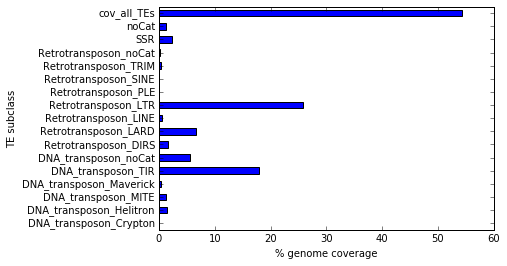

In [110]:
cov_all_TEs = df_REPET_classification.drop_duplicates([0,1])
cov_all_TEs = len(cov_all_TEs)

cov_per_class_df = cov_per_class.append(pd.DataFrame.from_dict({'cov_all_TEs': cov_all_TEs}, orient='index'))

cov_per_class_df.rename(columns={0: 'bp'}, inplace=True)

cov_per_class_df['%'] = round(cov_per_class_df['bp']/genome_size*100, 2)

cov_per_class_df.to_csv(out_dir+'/'+genome+'.REPET.summary.tab', sep='\t')

cov_per_class_df['%'].plot.barh()
plt.xlabel('% genome coverage')
plt.ylabel('TE subclass')

In [ ]:
cov_per_class/genome_size

In [ ]:
cov_per_class_noblast/genome_size

In [ ]:
(cov_per_class/genome_size*100).sum()

In [ ]:
(cov_per_class_noblast/genome_size*100).sum()

In [ ]:
len(df_REPET_classification)

In [ ]:
len(df_REPET_noblast_classification)

In [ ]:
len(df_REPET_noblast_classification.drop_duplicates([0,1]))/genome_size

In [ ]:
len(df_REPET_classification.drop_duplicates([0,1]))/genome_size

In [ ]:
df_REPET_classification.head()

In [ ]:
#look at the same graph with blast only searches and see what we get. Consider that a different parsing of ideas might be
#more appropriate in this case

## Below I am trying to sort out the cov files produced from bedfiles for each indiviudal TE element

In [ ]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id):
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id.split('_')[0] in list(code_dict.keys()):
        key = code_dict[_id.split('_')[0]].split(' ')[0]
        out_path = TE_path_dict[key]
    #everything without '_' at the end should be SSR
    elif '_' not in _id:
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [ ]:
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))

In [ ]:
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [ ]:
_id = pd.read_csv(out_dir+'/'+genome+'.REPET.ID_column.gff', header=None, sep='\t')[8].unique()
REPET_ID_bed = pybedtools.BedTool(out_dir+'/'+genome+'.REPET.ID_column.gff')
REPET_ID_bed = REPET_ID_bed.remove_invalid().saveas(out_dir+'/'+genome+'.REPET.ID_column.bedobject')


In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.

jobs = []
bed_file = g
total_jobs = len(_id)
job_count = 0
manager = multiprocessing.Manager()
TE_cov_df  = manager.dict()
while job_count < total_jobs:
    while [j.is_alive() for j in jobs].count(True) > 50:
        time.sleep(15)
        print("Waiting for Subset_id_classification to finish! More than 10 jobs running")
        print('%s jobs started' % job_count)
    if job_count +10 < total_jobs:
        for i in range(job_count, job_count+10):
            p = multiprocessing.Process(target=subset_id, args=([_id[i],TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
            
    else:
        for i in range(job_count, total_jobs+1):
            p = multiprocessing.Process(target=subset_id, args=([_id[i], TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))


In [ ]:
print(job_count)

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_q(_id_list, out_q):
    outdict ={}
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    for _id in _id_list:
    
        #ClassI are retrotransposon form blast
        if 'ClassI:' in _id:
            out_path = TE_path_dict['Retrotransposon']   
        #ClassII are DNA_transponson
        elif 'ClassII' in _id:
            out_path = TE_path_dict['DNA_transposon'] 
        #The rest with '_' should be REPET_TEs
        elif _id.split('_')[0] in list(code_dict.keys()):
            key = code_dict[_id.split('_')[0]].split(' ')[0]
            out_path = TE_path_dict[key]
        #everything without '_' at the end should be SSR
        elif '_' not in _id:
            out_path = TE_path_dict['SSR']
        out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
        result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
        cov_fn = out_fn.replace('gff','cov')
        cov = result.genome_coverage(dz=True,g=p_genome_file)
        cov.saveas(cov_fn)
        _len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
        outdict[_id] = _len
    out_q.put(outdict)
    #return pybedtools.BedTool(result.fn)

In [ ]:
#use multiprocessing to do the bedcov genome coverage per classification. Keep track if everything is already done.
import math
out_q = multiprocessing.Queue()
nproces = 30 #number of processors
chunksize = int(math.ceil(len(_id) / float(nproces)))
jobs = []
job_count = 0
#manager = multiprocessing.Manager()
#TE_cov_df  = manager.dict()
for i in range(nproces):
        p = multiprocessing.Process(target=subset_id_q, args=(_id[chunksize * i:chunksize * (i + 1)],out_q))
        jobs.append(p)
        p.start()
        job_count += 1
# Collect all results into a single result dict. We know how many dicts
# with results to expect.
resultdict = {}
for i in range(nproces):
    resultdict.update(out_q.get())

# Wait for all worker processes to finish
for p in jobs:
    p.join()

        
        
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))

In [ ]:
len(_id)

In [ ]:
p = multiprocessing.Pool(20)
p.map(subset_id, _id)

In [ ]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id_m(_id,):
    repet_prefix = 'Pst_104E_v12_p_ctg.REPET.TE_level'
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id.split('_')[0] in list(code_dict.keys()):
        key = code_dict[_id.split('_')[0]].split(' ')[0]
        out_path = TE_path_dict[key]
    #everything without '_' at the end should be SSR
    elif '_' not in _id:
        out_path = TE_path_dict['SSR']
    out_fn = out_path+'/'+repet_prefix+'.'+_id+'.gff'
    result = REPET_ID_bed.filter(id_filter, _id).saveas(out_fn)
    cov_fn = out_fn.replace('gff','cov')
    cov = result.genome_coverage(dz=True,g=p_genome_file)
    cov.saveas(cov_fn)
    #_len = len(pd.read_csv(cov_fn, header=None, sep='\t'))
    #_dict[_id] = _len
    #return pybedtools.BedTool(result.fn)

In [ ]:

jobs = []
bed_file = g
total_jobs = len(_id)
job_count = 0
manager = multiprocessing.Manager()
TE_cov_df  = manager.dict()

    while [j.is_alive() for j in jobs].count(True) > 10:
        time.sleep(15)
        print("Waiting for Subset_id_classification to finish! More than 10 jobs running")
        print('%s jobs started' % job_count)
    if job_count +10 < total_jobs:
        for i in range(job_count, job_count+10):
            p = multiprocessing.Process(target=subset_id, args=([_id[i],TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
            
    else:
        for i in range(job_count, total_jobs+1):
            p = multiprocessing.Process(target=subset_id, args=([_id[i], TE_cov_df]))
            jobs.append(p)
            p.start()
            job_count += 1
while set([j.is_alive() for j in jobs]) != {False}:
    time.sleep(15)
    print("Waiting for Subset_id_classification to finish!")
print("All Subset_id_classifications done! Totaling %i"% (job_count))


In [ ]:
for x in TE_cov_df.keys():
    print(x)

In [ ]:
[j.is_alive() for j in jobs].count(True)

In [ ]:
count = 0
while count < 10:
    count += 1
print(count)

In [ ]:
#this is REALLY slow for now. Would need to parallize this step. Look at the pool function of 
#multiprocessing

In [ ]:
[subset_id(x) for x in _id]

In [ ]:
#this caputures all REPET cov files for each indiviual TE.
class_cov_files = []
for dirpath, dirname, filenames in os.walk(cur_dir):
    #print(dirpath)
    #print(len(filenames))
    if len(filenames) == 0:  # empty folder
        continue
    cov_files = [dirpath +'/'+x for x in filenames if x.endswith('.cov') and 'classification' not in x ]
    for file in cov_files:
        class_cov_files.append(file)


In [ ]:
filenames

In [ ]:
!pwd

In [ ]:
len(cov_files)

In [ ]:

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Code long"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True)
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_noblast_classification = pd.concat(df_list)

cov_per_class_noblast = df_REPET_noblast_classification.pivot_table(values=1, columns= 'Code long', aggfunc='count')
cov_per_contig_per_class_noblast = df_REPET_noblast_classification.groupby([0, 'Code long'])[1].count()